# Perfil de Densidade a partir da simulação de um poço</br>

### Script desenvolvido por Victor Carreira
### Colaboração de Rodrigos Mota e Bijani

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import imageio as io
import plotly as ply
import plotly.graph_objs as go
import plotly.subplots as sub
import pandas as pd
import random
from PIL import Image

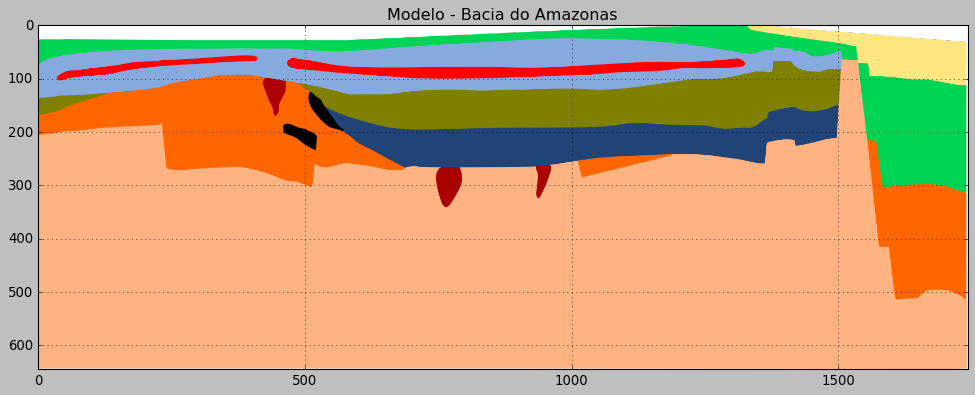

In [10]:
#Leitura da imagem (.png) com o modelo geológico e armazenando em uma matriz de cores (ma)
ma = io.imread("../figs/amazonas.png", as_gray=False, pilmode="RGBA")
plt.style.use(['classic']) #fundo cinza
plt.figure(figsize=(15.0,20.0)) #nova dimensao da figura
plt.title("Modelo - Bacia do Amazonas") #titulo da figura
plt.imshow(ma)
plt.grid()
plt.show()

In [11]:
#input do usuario, definindo as dimensoes do modelo na horizontal e na vertical
x_secao = 7000.0 #Horizontal
z_secao = 2000.0 #Vertical

#Criando os vetores de coordenadas (xi), com xm e o vetor de profundidade (zi), com zm.

#Convertendo de pixels para metros:
hz = np.shape(ma)[0]
hx = np.shape(ma)[1]

xi = np.linspace(0.0, x_secao, hx, endpoint=True)
zi = np.linspace(0.0, z_secao, hz, endpoint=True)

In [12]:
ma2 = np.array([[0.0]*np.shape(ma)[1]]*np.shape(ma)[0]) #np.(np.shape(ma))
image = Image.fromarray(ma)
print(np.shape(ma2))
print(np.shape(ma))

(644, 1743)
(644, 1743, 4)


In [13]:
# para fazer plots dentro do proprio jupyter sem a necessidade de conexao com a internet:
ply.offline.init_notebook_mode(connected=True)

# funcao go.Contour faz um countour plot usando como eixo x, o xi criado para coordenadas, como o eixo y, o zi
# criado para profunidades, e como o eixo z o plot de valores RGBA da matriz ma.
# além disso, na função go.countour está listando as configurações personalizadas para o colorbar

imagem = go.Contour(z=ma2,
                    x=xi,
                    y=zi
                   )
          

# a função go.Layout personaliza o layout do gráfico, alterando o layout dos eixos, da legenda, etc.
layout = go.Layout(
                    #Personalizando o titulo do gráfico: texto, tamanho da fonte, cor do texto, etc.
                    title=dict(text='Bacia do Amazonas',
                              font=dict(size=18,
                                        family='Arial, sans-serif',
                                        color='white'
                                        )
                               ),
    
                    #Personalizando o eixo x: posicao, cor, texto, etc.
                    xaxis=dict(title='Distância',
                               side='top',
                               color='white'
                              ),
    
                    #Personalizando o eixo y: posicao, cor, texto, etc.
                    yaxis=dict(title='Profundidade',
                               autorange='reversed', #possibilita inverter o eixo y.
                               color='white'
                              ),
    
                    #Personalizando a legenda: cor, texto, fonte, tamanho da fonte, etc.
                    legend=dict(font=dict(family='Arial, sans-serif',
                                          size=12,
                                          color='white'
                                         )
                               ),
    
                    images = [dict(source = image,
                                 xref = "x",
                                 yref = "y",
                                 x = 0,
                                 y = 0,
                                 sizex = 7000,
                                 sizey = 2000,
                                 sizing = "stretch",
                                 opacity = 0.9,
                                 layer = "above")],
    
                   # define o tamanho do gráfico, altura e largura, e o tamanhado da margem
                   #(l=left, r=right, b=bottom, t=top)
                   autosize=False,
                   width=900,
                   height=500,
                   margin=dict(l=60,
                               r=30,
                               b=20,
                               t=80
                               ),
                   paper_bgcolor='#7f7f7f', #cor do background da margem
                   plot_bgcolor='#c7c7c7', #cor do backgroud do gráfico
                   )

# a função go.FigureWidget cria a figura com os parametros utilizados na go.Countour e o layout na go.Layout
fig = go.FigureWidget(data=[imagem], layout=layout)

#Selecionando as configurações dos dados de fig
teste = fig.data[0]

# Definindo listas vazias que serão usadas na função de callback
x_data = []
y_data = []
indx = []
indy = []

# Criando a função de callback
# Para selecionar o ponto inicial e final da perfuração simulada do poço sintético 
def select_point(trace, points, selector):
    x = list(teste.x)
    y = list(teste.y)
    print(selector)
    for i in points.point_inds:
        y_data.append(zi[i[0]])
        x_data.append(xi[i[1]])
        indx.append(i[1])
        indy.append(i[0])
        if selector.shift == True:
            fig.add_scatter(x=x_data, y=y_data, name ='Poço MB', showlegend= True)

# Sempre que clicar no gráfico chamará a função de callback
teste.on_click(select_point)

# plot a figura na tela:
fig

####### É NECESSÁRIO ESCOLHER DOIS PONTOS CLICANDO NO GRÁFICO GERADO PARA RODAR O RESTANTE DO SCRIPT #######

FigureWidget({
    'data': [{'type': 'contour',
              'uid': '1fad5133-2436-4949-b90a-e28ccfba7247',
 …

## É NECESSÁRIO ESCOLHER DOIS PONTOS CLICANDO NO GRÁFICO GERADO PARA RODAR O RESTANTE DO SCRIPT 

### Criando o poço sintético

In [5]:
#apenas rodar quando escolher dois pontos clicando no gráfico acima
#definindo a dimensão do poço sintético
mb = (ma[indy[0]-1:indy[1], indx[0]-1:indx[0]])

### Leitura do banco de dados de input, fornecido pelo usuario (litologias, RBG, rho)

In [6]:
cab = ['lito', 'R','G','B','A', 'rho', 'phi']
data = pd.read_csv('../dados/input_usuario.txt', sep='\s+', names=cab, header=0 )
data

,lito,R,G,B,A,rho,phi
0,Sandstone,255,230,128,255,NaN,NaN
1,Shale2,0,212,85,255,2.40,40.0
2,Diabase,255,0,0,255,2.10,30.0
3,Dolomite,135,170,222,255,2.05,NaN
4,Basalt,0,0,0,255,2.80,23.0
5,Shale1,128,128,0,255,NaN,NaN
6,Halite,33,68,120,255,2.20,18.0
7,Granit,170,0,0,255,NaN,NaN
8,Conglomerate,255,102,0,255,NaN,NaN
9,Crystaline,255,179,128,255,NaN,NaN


## Teste para comparar litologias do poço perfurado com a cor estabelecida:


In [7]:
# Calculando a norma euclidiana para cada litologia, distancia entre o R, G, B e A:
D = (data.R**2 + data.G**2 + data.B**2 + data.A**2)**0.5
#adicionando a coluna 'DistCor' na tabela de dados:
data['DistCor'] = D
data

,lito,R,G,B,A,rho,phi,DistCor
0,Sandstone,255,230,128,255,NaN,NaN,446.468364
1,Shale2,0,212,85,255,2.40,40.0,342.336092
2,Diabase,255,0,0,255,2.10,30.0,360.624458
3,Dolomite,135,170,222,255,2.05,NaN,401.788502
4,Basalt,0,0,0,255,2.80,23.0,255.000000
5,Shale1,128,128,0,255,NaN,NaN,312.718723
6,Halite,33,68,120,255,2.20,18.0,291.784167
7,Granit,170,0,0,255,NaN,NaN,306.471858
8,Conglomerate,255,102,0,255,NaN,NaN,374.771931
9,Crystaline,255,179,128,255,NaN,NaN,422.463016


In [9]:
# Calculando a norma euclidiana para cada profundidade do poço mb, distancia entre o R, G, B e A:
# Atencao: somente vale para 1 poco! 
lito = []
for i in range(len(mb)):
    de = (mb[i,0,0]**2 + mb[i,0,1]**2 + mb[i,0,2]**2 + mb[i,0,3]**2)**0.5
    lito.append(de)

In [10]:
#Criando o vetor de profundidade do poço:
prof = np.linspace(zi[indy[0]], zi[indy[1]], len(mb))
a = (prof[1]-prof[0])

In [11]:
#Criando um dicionário vazio com a mesma dimensão do poço mb para cada tipo de litologia
litologias={}
for i in range(len(data)):
    dicio={data.lito[i]: [0]*len(mb)}
    litologias.update(dicio)

In [12]:
# construindo o perfil de densidade:
rhob = [0.0]*len(mb)
# construindo o perfil de porosidade:
phi = [0.0]*len(mb)

for i in range(len(mb)):
    for k in range(len(data.lito)):
        if lito[i] == data.DistCor[k]:
            #preenchendo o perfil phi com os valores do dataframe de input
            phi[i] = data.phi[k]
            rhob[i] = data.rho[k]
            #preenchendo o dicionário de litologia com o valor 1 na posição daquela litologia no poço
            litologias[data.lito[k]][i]=1

In [16]:
## Adiconando ruído randômico gaussiano normal:
rhob_noise = np.zeros(len(rhob))
test=np.copy(rhob_noise)
for i in range(len(rhob)):
    rhob_noise[i] = random.gauss(rhob[i], 0.2)
    if rhob[i] == 0.0:
        rhob_noise[i] = np.nan

## Simulação do processo de compactacao usando a seguinte equacao de Rao, 1994: <br>

## $$ \Delta \rho(z) = \frac{ \Delta\rho_0 ~ \beta ^2}{ (\beta + z)^2 }   $$



In [17]:
beta = 100.0
rho0 = 2.05
rc = rho0 * beta**2/(beta+prof)**2

In [18]:
rc2 = rhob_noise+rc[::-1]

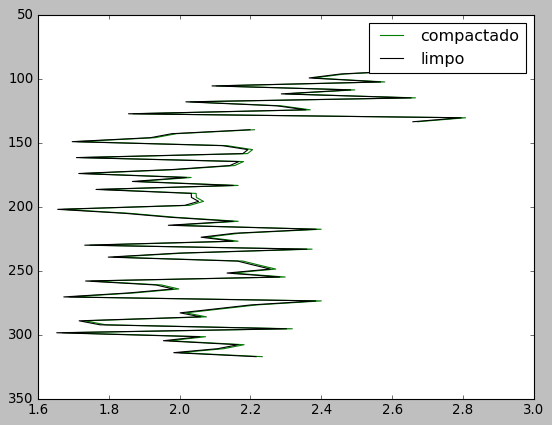

In [19]:
plt.plot(rc2, prof,'-g', label='compactado')
plt.plot(rhob_noise, prof,'-k', label='limpo')

plt.legend()
plt.gca().invert_yaxis()

In [ ]:
# para fazer plots dentro do proprio script sem a necessidade de conexao com a internet:
ply.offline.init_notebook_mode(connected=True)

#-------------------------------Scatter plot do rhob com a profundidade----------------------------------#

# funcao go.Scatter faz um scatter plot usando como eixo x, o rhob_noise criado com os dados de rhob e
# adicionado ruído, como o eixo y, a prof criada para profundidades.

rhob_graph = [go.Scatter(x=rhob_noise, y=prof, name='RHOB', showlegend = True)]
#--------------------------------------------------------------------------------------------------------#

#-------------------------------Configuracao do Layout do Scatter Plot-----------------------------------#

# Define o layout do plot, como título dos eixos, posição dos eixos, cor da letra, etc
layout = go.Layout(xaxis=dict(title=dict(#text='Perfil de Densidade',
                                         font=dict(size=16,
                                                   family='Arial, sans-serif')
                                         ),
                              side ='top',
                              color = 'white'
                              ),
                   yaxis=dict(title=dict(text='Profundidade',
                                         font=dict(size=16,
                                                   family='Arial, sans-serif'
                                                  )
                                         ),
                              autorange='reversed',
                              color='white'
                              ),
                   legend=dict(font=dict(family='Courier New',
                                         size=12,
                                         color = 'white'
                                        )
                               ),
                   # define o tamanho do gráfico, altura e largura, e o tamanhado da margem
                   # (l=left, r=right, b=bottom, t=top)
                   autosize=False,
                   width=450,
                   height=800,
                   margin=dict(l=70,
                               r=20,
                               b=20,
                               t=80
                               ),
                   paper_bgcolor='#7f7f7f', #cor do background da margem
                   plot_bgcolor='#c7c7c7', #cor do backgroud do gráfico
                   title = dict(text='Perfil de Densidade',
                                font=dict(size=18,
                                          family='Arial, sans-serif',
                                          color = 'white'
                                          )
                                )
                   )
#--------------------------------------------------------------------------------------------------------#

# Criando o plot fig com a juncao dos dados rhob_graph, definido no scatter plot, e o layout configurado acima
fig = go.FigureWidget(data=rhob_graph, layout=layout)

# Mostrando Fig na tela
fig

In [ ]:
# para fazer plots dentro do proprio script sem a necessidade de conexao com a internet:
ply.offline.init_notebook_mode(connected=True)

# Criando um subplot fig com uma linha e duas colunas, e compartilhando o mesmo eixo y
fig = sub.make_subplots(rows=1, cols=2, subplot_titles=['Litologias', 'Perfil RHOB'], shared_yaxes=True)

# Trace com scatter na segunda posicao do sub plot, linha 1 coluna 2.
fig.add_trace(go.Scatter(x=rhob_noise, y=prof, name= 'Rhob'),
              row=1,
              col=2
             )
# Varios Traces na primeira posicao do sub plot, linha 1 coluna 1.
for i in range(len(data)):
    fig.add_trace(go.Bar(x=litologias[data.lito[i]],
                         y=prof,
                         orientation='h',
                         showlegend= True,
                         name= data.lito[i],
                         width = a
                        ),
                  row=1,
                  col=1
                  )

#-------------------------------Configuracao do Layout do Sub Plot-----------------------------------#

# Define o layout do plot, como título dos eixos, posição dos eixos, cor da letra, etc
fig.update_layout(go.Layout(xaxis=dict(side ='bottom',
                                       color='white'
                                       ),
                            xaxis2=dict(side='bottom',
                                        color='white'
                                        ),
                            yaxis=dict(title='Profundidade',
                                       autorange='reversed',
                                       color = 'white'
                                       ),
                            legend=dict(font=dict(family='Courier New',
                                                  size=12,
                                                  color = 'white'
                                                 )
                                        ),
                            # define o tamanho do gráfico, altura e largura, e o tamanhado da margem 
                            # (l=left, r=right, b=bottom, t=top)
                            autosize=False,
                            width=600,
                            height=800,
                            margin=dict(l=50,
                                        r=30,
                                        b=20,
                                        t=60
                                        ),
                            paper_bgcolor='#7f7f7f', #cor do background da margem
                            plot_bgcolor='#c7c7c7', #cor do backgroud do gráfico
                            )
                 )
#--------------------------------------------------------------------------------------------------------#

# Mostrando o plot fig na tela:
fig.show()

In [ ]:
# para fazer plots dentro do proprio script sem a necessidade de conexao com a internet:
ply.offline.init_notebook_mode(connected=True)

# Criando um subplot fig com uma linha e duas colunas, e compartilhando o mesmo eixo y
fig = sub.make_subplots(rows=1, cols=2, subplot_titles=['Litologias', 'Perfil RHOB'], shared_yaxes=True)

# Trace com scatter na segunda posicao do sub plot, linha 1 coluna 2.
fig.add_trace(go.Scatter(x=rhob_noise, y=prof, name= 'Rhob'),
              row=1,
              col=2
              )

# Varios Traces na primeira posicao do sub plot, linha 1 coluna 1.
for i in range(len(data)):
    fig.add_trace(go.Scatter(x=litologias[data.lito[i]], y=prof, showlegend= True, name= data.lito[i], fill='toself'),
              row=1,
              col=1
              )

#-------------------------------Configuracao do Layout do Sub Plot-----------------------------------#

# Define o layout do plot, como título dos eixos, posição dos eixos, cor da letra, etc
fig.update_layout(go.Layout(xaxis=dict(side ='bottom',
                                       color = 'white',
                                       ),
                            xaxis2=dict(side ='bottom',
                                        color = 'white',
                                        ),
                            yaxis=dict(title='Profundidade',
                                       autorange='reversed',
                                       color = 'white'
                                       ),
                            legend=dict(font=dict(family='Courier New',
                                                  size=12,
                                                  color = 'white'
                                                 )
                                        ),
                            # define o tamanho do gráfico, altura e largura, e o tamanhado da margem 
                            # (l=left, r=right, b=bottom, t=top)
                            autosize=False,
                            width=600,
                            height=800,
                            margin=dict(l=50,
                                        r=30,
                                        b=20,
                                        t=60
                                        ),
                            paper_bgcolor='#7f7f7f', #cor do background da margem
                            plot_bgcolor='#c7c7c7', #cor do backgroud do gráfico
                            )
                 )
#--------------------------------------------------------------------------------------------------------#

# Mostrando o plot fig na tela:
fig.show()

In [ ]:
#plot da coluna estratigrafica e do perfil usando o matplotlib
#plt.figure(figsize=(8,10))
#plt.fill_betweenx(prof, litologias[0], step = 'pre', color = 'gold', label = data.lito[0])
#plt.fill_betweenx(prof, litologias[1], step = 'pre', color = 'sandybrown', label = data.lito[1])
#plt.fill_betweenx(prof, litologias[2], step = 'pre', color = 'olive', label = data.lito[2])
#plt.fill_betweenx(prof, litologias[3], step = 'pre', color = 'darkgreen', label = data.lito[3])
#plt.fill_betweenx(prof, litologias[4], step = 'pre', color = 'blue', label = data.lito[4])
#plt.legend()
#plt.title('Litologias')
#plt.gca().invert_yaxis()
#plt.grid()
#plt.show()

## TODO:
### 0) Comentar todos os passos do scritp, pufavôoooo!
### 1) Ver como plotar a matriz de cor RGBA no plotly;
### 2) fazer o perfil de VS a partir de rhob (Gardner).
### 3) Organizar a parte da compactação (soma do rhob_noise com o rc compactado)
### 4) Repetir o processo para as litolog

# Para saber mais sobre a Plotly:

### https://plot.ly/python/
### https://plot.ly/python/contour-plots/
### https://plot.ly/python/click-events/#update-points-using-a-click-callback